In [1]:
import os
os.chdir('../')

import functools
import gin
import time
import numpy as np
import torch

from nerf import datasets
from nerf import models
from nerf import utils

import numpy as np
import cv2
from PIL import Image
from copy import deepcopy
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

from tqdm.notebook import tqdm
import moviepy.editor as mpy


def render_image(model, rays, args):
    with torch.no_grad():
        pred_color, pred_disp, pred_acc = utils.render_image(
            functools.partial(model, randomized=True),
            rays,
            'llff' in args.data_dir.lower(),
            chunk=args.chunk,
            disable=True,
        )
    return pred_color, pred_disp, pred_acc


def make_gif(frames, filename):
    clip = mpy.ImageSequenceClip(frames, fps=10)
    clip.write_gif(filename)


args = [
    "--gin_files", "./configs/unity.py", "./configs/c64f128.py",
    "--data_dir", "../data/unity/face1",
    "--train_dir", "../logs/face1b",
]
args = utils.define_args(args)
gin.parse_config_files_and_bindings(args.gin_files, None)

device = "cuda:0"
dataset = datasets.get_dataset("test", args)
model, state = models.get_model_state(args, device=device, restore=True)

 Load Unity ../data/unity/face1 split test
* restore ckpt from ../logs/face1b/step-000500000.ckpt.


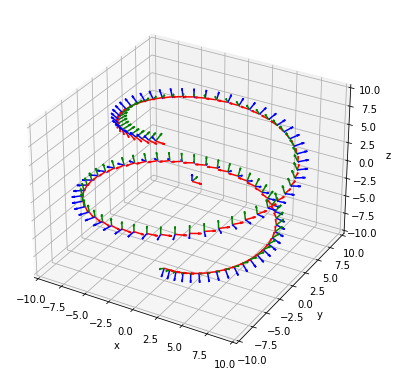

In [2]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, auto_add_to_figure=False)
l = 10
ax.set_xlim(-l, l); ax.set_ylim(-l, l); ax.set_zlim(-l, l)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b") 

for i in range(dataset.size):
    c2w = deepcopy(dataset.camtoworlds[i])

    x, y, z = c2w[:3,3]
    ax.scatter(x, y, z, c='blue', s=0.1)
    x_c = np.array([[1,0,0]]).T; x_w = c2w[:3,:3].dot(x_c)
    dx, dy, dz = x_w[:,0]
    ax.quiver(x, y, z, dx, dy, dz, length=1, color="r")
    x_c = np.array([[0,1,0]]).T; x_w = c2w[:3,:3].dot(x_c)
    dx, dy, dz = x_w[:,0]
    ax.quiver(x, y, z, dx, dy, dz, length=1, color="g")
    x_c = np.array([[0,0,1]]).T; x_w = c2w[:3,:3].dot(x_c)
    dx, dy, dz = x_w[:,0]
    ax.quiver(x, y, z, dx, dy, dz, length=1, color="b")

fig.add_axes(ax)
plt.show()

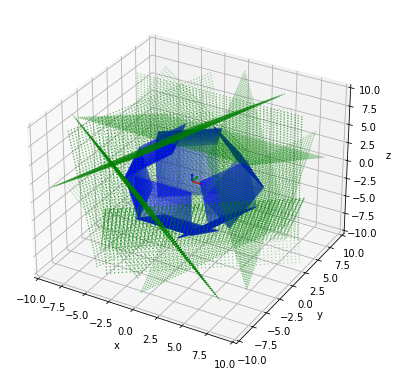

In [3]:
t_n, t_f = model.near, model.far
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, auto_add_to_figure=False)
l = 10
ax.set_xlim(-l, l); ax.set_ylim(-l, l); ax.set_zlim(-l, l)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b") 

for idx in range(0, len(dataset.rays.origins), 10):
    o = dataset.rays.origins[idx]
    d = dataset.rays.directions[idx]

    # render lower limit（blue）
    x_n, y_n, z_n = (o + d * t_n)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_n, y_n, z_n, c='blue', s=0.1)
    # render upper limit (green)
    x_f, y_f, z_f = (o + d * t_f)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_f, y_f, z_f, c='green', s=0.1)

fig.add_axes(ax)
plt.show()

In [3]:
os.makedirs("temp1/", exist_ok=True)
skip = 2
for idx in tqdm(range(dataset.size)):
    rays = utils.namedtuple_map(lambda r: r[idx, ::skip, ::skip], dataset.rays)
    rays = utils.namedtuple_map(
        lambda z: torch.from_numpy(z.copy()).to(device), rays)
    pred_color, pred_disp, pred_acc = render_image(model, rays, args)
    pred_color = np.clip(pred_color.cpu().numpy() * 255, 0, 255).astype(np.uint8)
    pred_color = cv2.cvtColor(pred_color, cv2.COLOR_BGR2RGB)
    cv2.imwrite("temp1/pred_{:03}.png".format(idx), pred_color)

  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
frames = []
for idx in range(dataset.size):
    frame = cv2.imread("temp1/pred_{:03}.png".format(idx))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
make_gif(frames, "pred.gif")

frames = []
for idx in range(dataset.size):
    frame = dataset.images[idx]
    frame = np.clip(frame * 255, 0, 255).astype(np.uint8)
    frame = cv2.resize(frame, (400,400))
    frames.append(frame)
make_gif(frames, "true.gif")

MoviePy - Building file pred.gif with imageio.


MoviePy - Building file true.gif with imageio.


In [4]:
camtoworlds = []

N = 30
r = 10.
for i in range(N):
    lat = np.deg2rad(0.)
    lon = np.deg2rad(i / N * 360.)

    # default: (x, y) = (r, 0)
    mat = np.eye(3).astype(np.float32)
    mat = mat.dot(Rotation.from_euler('xyz', (90,0,90), degrees=True).as_matrix())
    mat = mat.dot(Rotation.from_euler('xyz', (-lat,lon,0)).as_matrix())

    c2w = np.eye(4).astype(np.float32)
    c2w[:3, :3] = mat
    z = r * np.sin(lat)
    x = r * np.cos(lat) * np.cos(lon)
    y = r * np.cos(lat) * np.sin(lon)
    c2w[:3,3] = np.array([x,y,z], dtype=np.float32)
    camtoworlds.append(c2w)
camtoworlds = np.array(camtoworlds, dtype=np.float32)

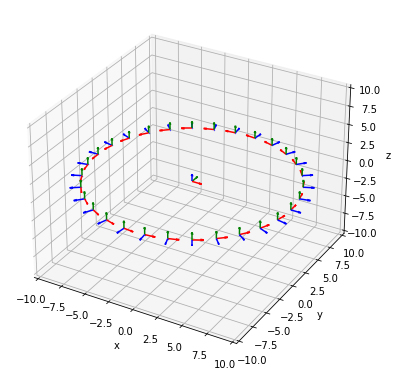

In [5]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, auto_add_to_figure=False)
l = 10
ax.set_xlim(-l, l); ax.set_ylim(-l, l); ax.set_zlim(-l, l)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
# ワールド座標
ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b")

for i in range(0,len(camtoworlds)):
    c2w = deepcopy(camtoworlds[i])

    x, y, z = c2w[:3,3]
    ax.scatter(x, y, z, c='blue', s=0.1)
    x_c = np.array([[1,0,0]]).T; x_w = c2w[:3,:3].dot(x_c)
    dx, dy, dz = x_w[:,0]
    ax.quiver(x, y, z, dx, dy, dz, length=1, color="r")
    x_c = np.array([[0,1,0]]).T; x_w = c2w[:3,:3].dot(x_c)
    dx, dy, dz = x_w[:,0]
    ax.quiver(x, y, z, dx, dy, dz, length=1, color="g")
    x_c = np.array([[0,0,1]]).T; x_w = c2w[:3,:3].dot(x_c)
    dx, dy, dz = x_w[:,0]
    ax.quiver(x, y, z, dx, dy, dz, length=1, color="b")

fig.add_axes(ax)
plt.show()

In [6]:
dataset.camtoworlds = camtoworlds
dataset._generate_rays()

In [7]:
os.makedirs("temp2/", exist_ok=True)
skip = 2
for idx in tqdm(range(len(camtoworlds))):
    rays = utils.namedtuple_map(lambda r: r[idx, ::skip, ::skip], dataset.rays)
    rays = utils.namedtuple_map(
        lambda z: torch.from_numpy(z.copy()).to(device), rays)
    pred_color, pred_disp, pred_acc = render_image(model, rays, args)
    pred_color = np.clip(pred_color.cpu().numpy() * 255, 0, 255).astype(np.uint8)
    pred_color = cv2.cvtColor(pred_color, cv2.COLOR_BGR2RGB)
    cv2.imwrite("temp2/pred_{:03}.png".format(idx), pred_color)

  0%|          | 0/30 [00:00<?, ?it/s]

In [9]:
frames = []
for idx in range(len(camtoworlds)):
    frame = cv2.imread("temp2/pred_{:03}.png".format(idx))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
make_gif(frames, "rotate.gif")

MoviePy - Building file rotate.gif with imageio.
